## Fraud Analytics(CS6890)

### Assignment No.1
**Identify clusters using (Node2Vec Embedding, Spectral, and GCN) embeddings**


Group Members :

1) Sanket Rathod (CS23MTECH11033)

2) Sanket Deone (CS23MTECH11034)

3) Akshay Kumar (CS23MTECH11022)

4) Abhishree Khangar (CS23MTECH11021)

5) Arif Khan (CS23MTECH11024)

# Node2vec Embedding

In [30]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import networkx as nx
from node2vec import Node2Vec
import matplotlib.pyplot as plt
import warnings

In [31]:
# Load the data
data = pd.read_csv('drive/MyDrive/Payments.csv')

In [32]:
#data = data.head(1000)

In [33]:
# Create a graph from the dataframe
G = nx.from_pandas_edgelist(data, 'Sender', 'Receiver', edge_attr=True)

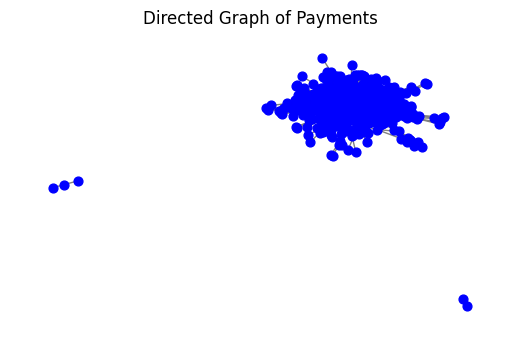

In [34]:
# Visualize the graph
plt.figure(figsize=(5, 3))
nx.draw(G, with_labels=False, node_color='blue', node_size=40, edge_color='gray', linewidths=1)
plt.title('Directed Graph of Payments')
plt.show()

In [35]:
data.head()

,Sender,Receiver,Amount
0,1309,1011,123051
1,1309,1011,118406
2,1309,1011,112456
3,1309,1011,120593
4,1309,1011,166396


In [36]:
# Create a directed graph
G = nx.from_pandas_edgelist(data, 'Sender', 'Receiver', ['Amount'], create_using=nx.DiGraph)

In [37]:
# Example: Get the total amount sent from node 1309 to 1011
total_amount = sum([d['Amount'] for _, _, d in G.out_edges(1309, data=True)])
print(total_amount)

6372434


In [38]:
# Generate walks
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)

Computing transition probabilities:   0%|          | 0/799 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [39]:
# Train a Node2Vec model
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [40]:
embedding_1309 = model.wv.get_vector('1309')

In [41]:
# Get node2vec embeddings for all nodes
node_embeddings = {node: model.wv.get_vector(str(node)) for node in G.nodes()}

In [42]:
print(len(node_embeddings))

799


In [43]:
# Cluster embeddings
X = [node_embeddings[node] for node in G.nodes]

In [44]:
print(len(X))

799


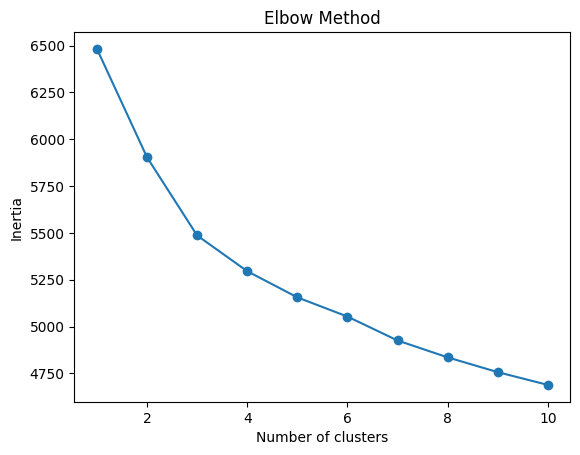

In [45]:
# Suppress warnings for KMeans
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Calculate the sum of squared distances for different values of k
    inertias = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)

# Plot the elbow
plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [46]:
# Applying Kmeans clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
cluster_labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


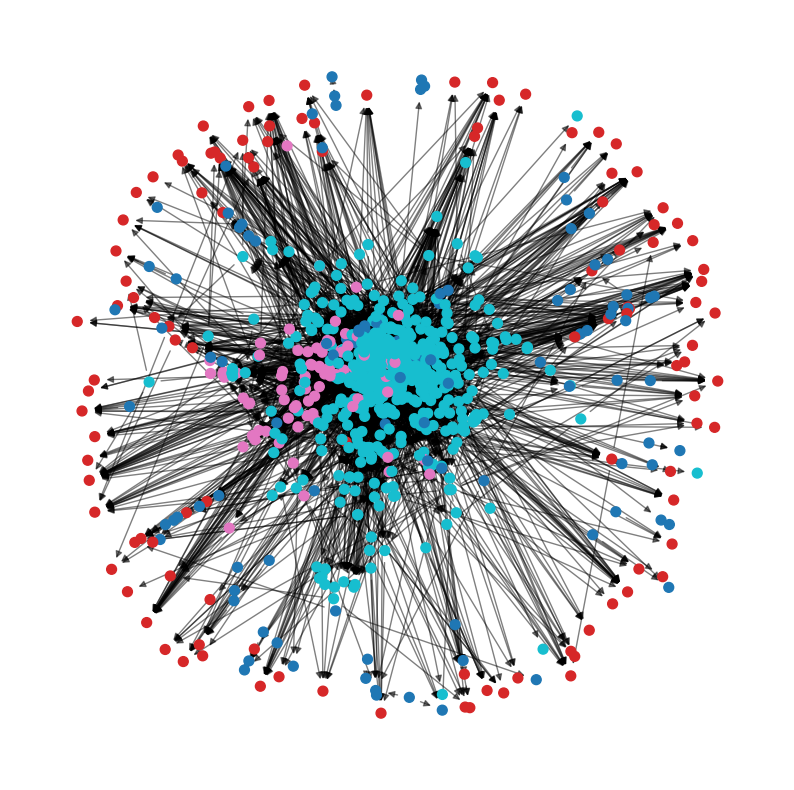

In [47]:
# Adding cluster labels to the graph nodes
nx.set_node_attributes(G, {node: label for node, label in zip(G.nodes, cluster_labels)}, 'cluster')

# Creating the layout for the nodes
pos = nx.spring_layout(G)

# Drawing the graph
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=cluster_labels, cmap=plt.cm.tab10)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.axis('off')
plt.show()


# Spectral Embedding

In [48]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import SpectralEmbedding
from mpl_toolkits.mplot3d import Axes3D

In [49]:
# Aggregate Amounts for each Sender-Receiver pair
aggregated_df = data.groupby(['Sender', 'Receiver'])['Amount'].sum().reset_index()

In [50]:
# Determine the maximum sender and receiver IDs
max_sender_id = aggregated_df['Sender'].max()
max_receiver_id = aggregated_df['Receiver'].max()
num_nodes = max(max_sender_id, max_receiver_id) + 1

In [51]:
# Create adjacency matrix
adjacency_matrix = np.zeros((num_nodes, num_nodes))
for index, row in aggregated_df.iterrows():
    # Extracting the index of the sender node
    sender_idx = row['Sender']
    # Extracting the index of the Receiver node
    receiver_idx = row['Receiver']
    # Extracting the amount
    amount = row['Amount']
    # Incrementing the adjacency matrix at the sender and receiver indices by the amount.
    adjacency_matrix[sender_idx][receiver_idx] += amount

In [52]:
# Apply Spectral embedding
spectral_embedding = SpectralEmbedding(n_components=3)
node_embeddings = spectral_embedding.fit_transform(adjacency_matrix)

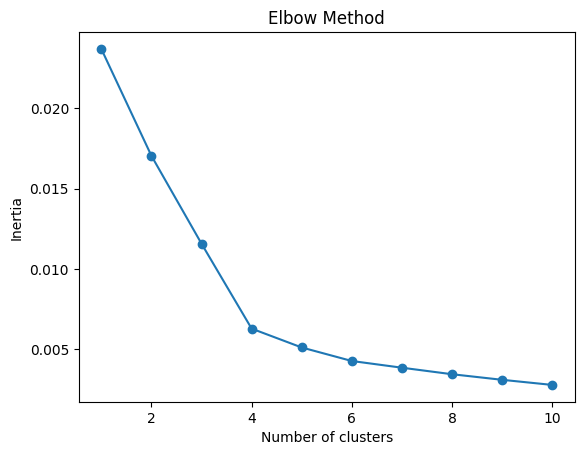

In [53]:
# ignoring warnings for KMeans
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Calculate the sum of squared distances for different values of k
    inertias = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(node_embeddings)
        inertias.append(kmeans.inertia_)

# Plot the elbow
plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [54]:
# Perform clustering
kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(node_embeddings)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [55]:
print("Node Embeddings:")
print(node_embeddings.shape)
print("Clusters:")
print(clusters.shape)

Node Embeddings:
(2191, 3)
Clusters:
(2191,)


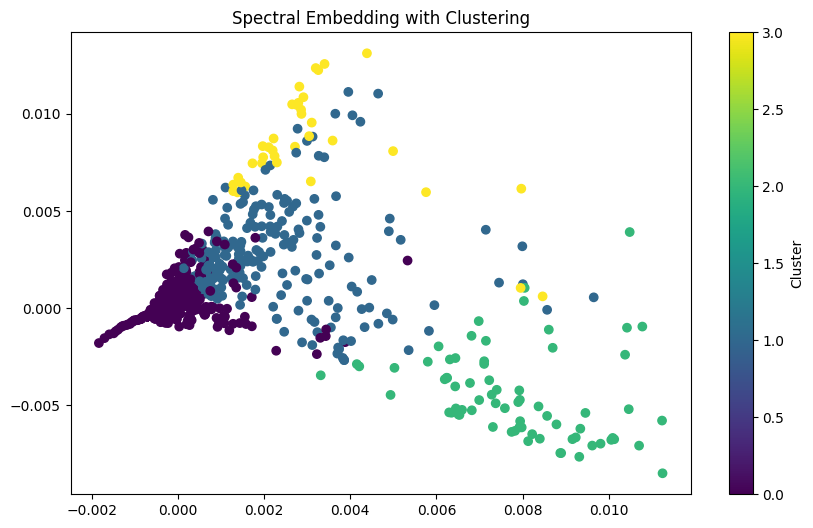

In [56]:
# PLoting the graph for Spectral Embedding
plt.figure(figsize=(10, 6))
plt.scatter(node_embeddings[:, 0], node_embeddings[:, 1], cmap='viridis', c=clusters)
plt.title('Spectral Embedding with Clustering')
plt.colorbar(label='Cluster')
plt.show()

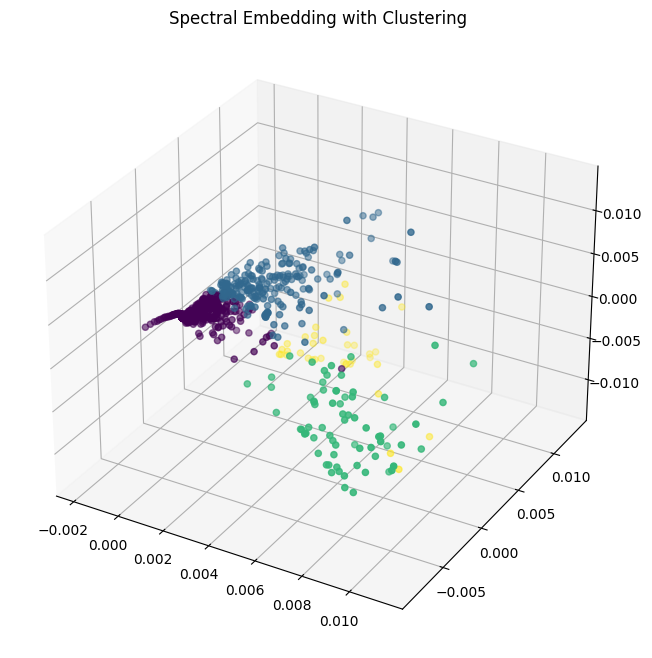

In [57]:
# Visualize the embeddings in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(node_embeddings[:, 0], node_embeddings[:, 1], node_embeddings[:, 2], cmap='viridis',  c=clusters)
ax.set_title('Spectral Embedding with Clustering')
plt.show()

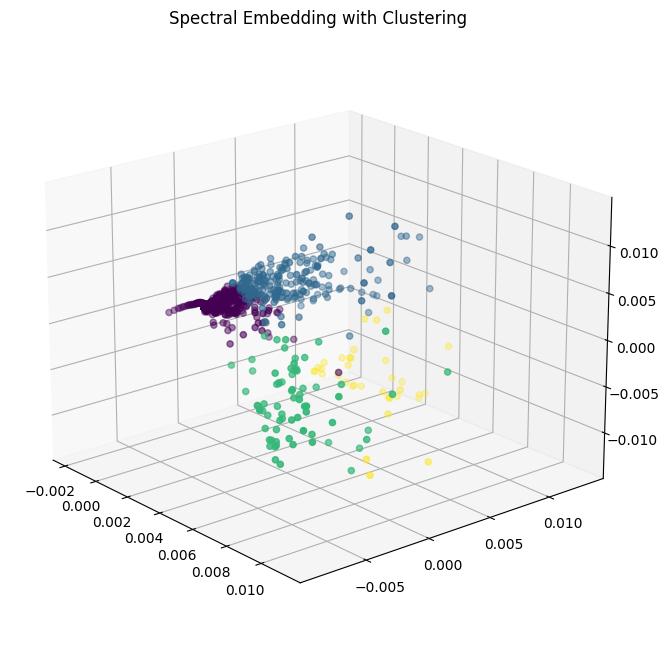

In [58]:
# Visualizing the embeddings in 3D with a different angle
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20, azim=-40)  # Change the elevation and azimuth angles
ax.scatter(node_embeddings[:, 0], node_embeddings[:, 1], node_embeddings[:, 2],  c=clusters)
ax.set_title('Spectral Embedding with Clustering')
plt.show()

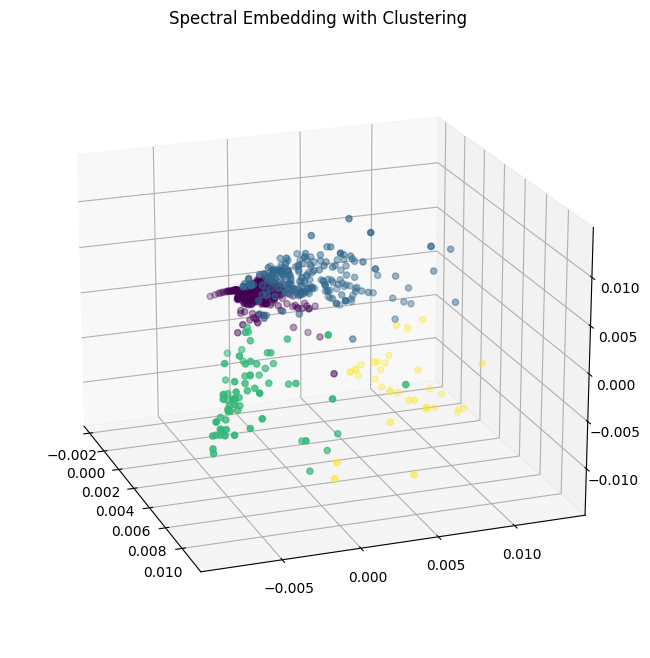

In [59]:
# Visualizing the embeddings in 3D with a different angle
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20, azim=-20)  # Change the elevation and azimuth angles
ax.scatter(node_embeddings[:, 0], node_embeddings[:, 1], node_embeddings[:, 2],  c=clusters)
ax.set_title('Spectral Embedding with Clustering')
plt.show()

# GCN Embedding

In [61]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.cluster import KMeans
import numpy as np
import networkx as nx

In [62]:
# Creating a directed graph from the dataframe
G = nx.from_pandas_edgelist(data, 'Sender', 'Receiver', edge_attr=True)

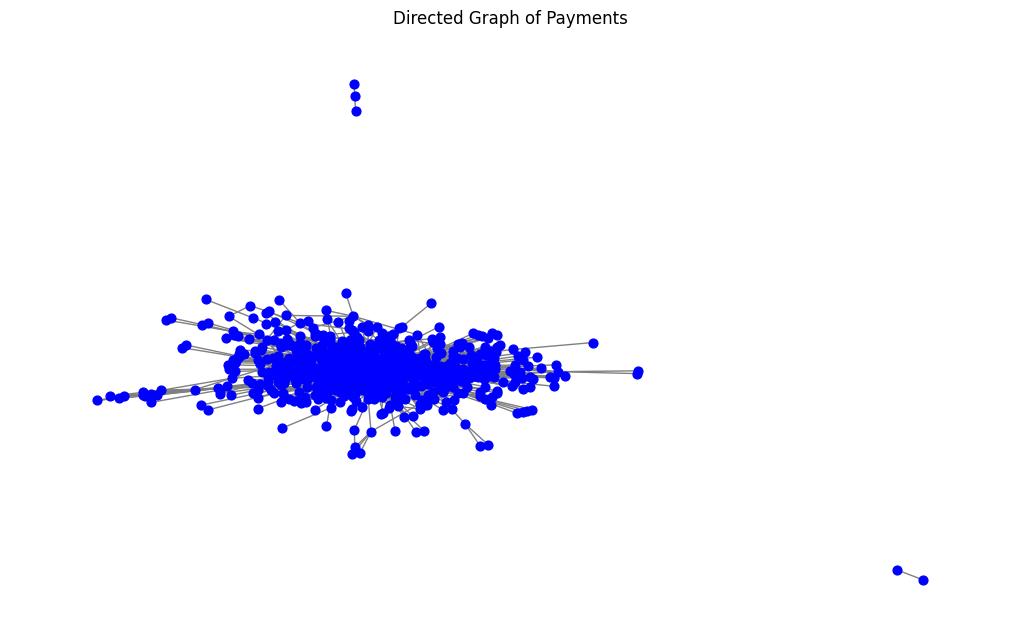

In [63]:
# Visualizing the graph
plt.figure(figsize=(10, 6))
nx.draw(G, with_labels=False, node_color='blue', node_size=40, edge_color='gray', linewidths=1)
plt.title('Directed Graph of Payments')
plt.show()

In [64]:
# Convert to PyTorch Geometric Data
edge_index = torch.tensor(list(G.edges)).t().contiguous()
# Featureless inputs
x = torch.eye(max(G.nodes) + 1)

In [65]:
# Defining the GCN Model
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(x.size(1), 16)
        self.conv2 = GCNConv(16, 8)
        self.conv3 = GCNConv(8, 4)
    # forward Layer for GCN model
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return x

# Instantiating the Model
model = GCN()

In [66]:
# Applying GCN
embeddings_gcn = model(x, edge_index).detach().numpy()

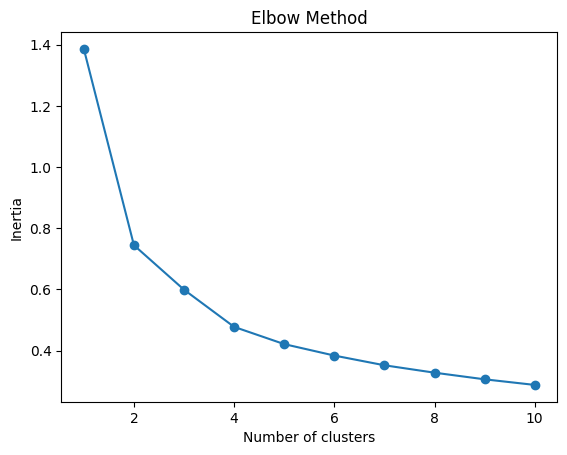

In [67]:
# ignoring warnings for KMeans
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Calculate the sum of squared distances for different values of k
    inertias = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(embeddings_gcn)
        inertias.append(kmeans.inertia_)

# Plot the elbow
plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [68]:
# Cluster the Embeddings
kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(embeddings_gcn)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [69]:
# Print the clusters
print(clusters.size)

2191


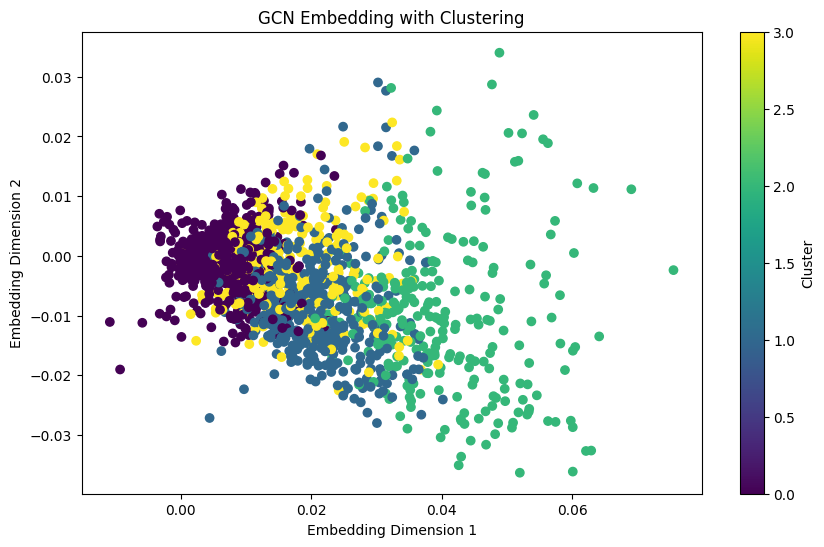

In [70]:
# Plotting the graph for GCN Embedding
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_gcn[:, 0], embeddings_gcn[:, 1], cmap='viridis', c=clusters)
plt.title('GCN Embedding with Clustering')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.colorbar(label='Cluster')
plt.show()

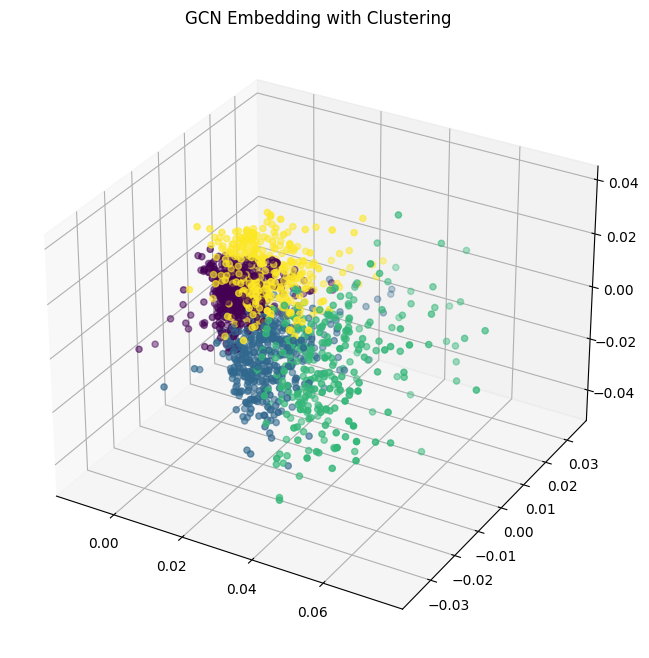

In [71]:
# Visualizing the embeddings in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embeddings_gcn[:, 0], embeddings_gcn[:, 1], embeddings_gcn[:, 2], cmap='viridis',  c=clusters)
ax.set_title('GCN Embedding with Clustering')
plt.show()

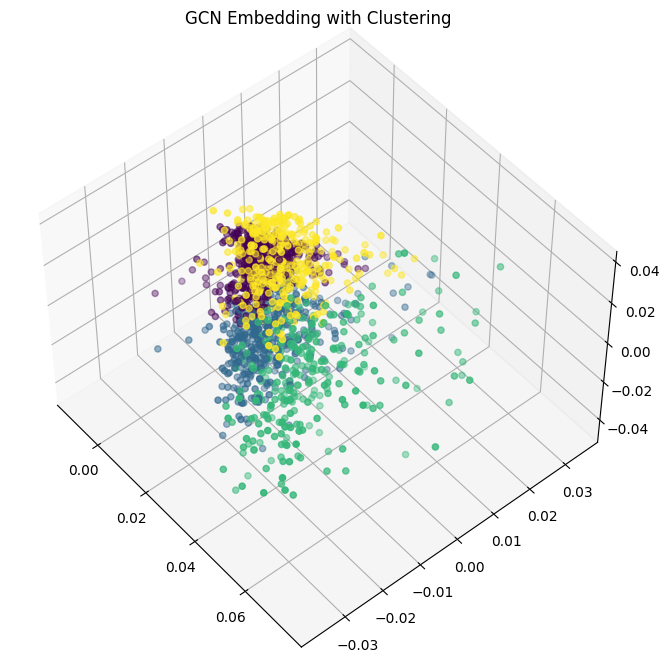

In [72]:
# Visualizing the embeddings in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=50, azim=-40)
ax.scatter(embeddings_gcn[:, 0], embeddings_gcn[:, 1], embeddings_gcn[:, 2], cmap='viridis',  c=clusters)
ax.set_title('GCN Embedding with Clustering')
plt.show()

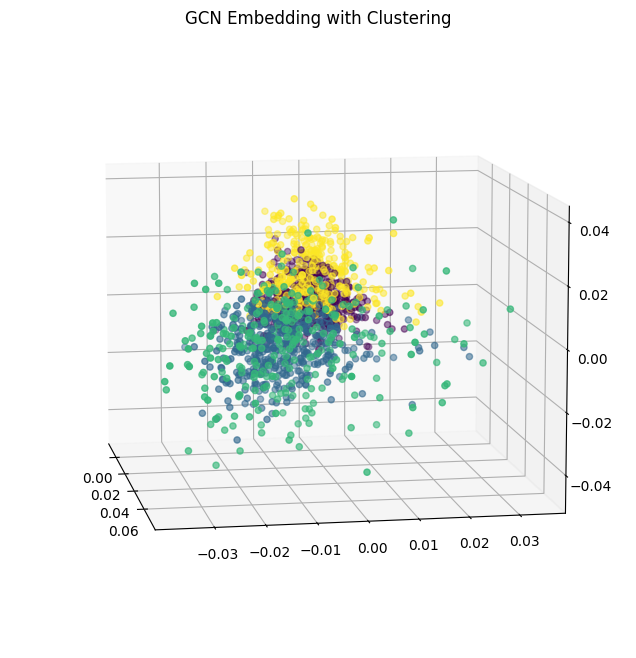

In [73]:
# Visualizing the embeddings in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=10, azim=-10)
ax.scatter(embeddings_gcn[:, 0], embeddings_gcn[:, 1], embeddings_gcn[:, 2], cmap='viridis',  c=clusters)
ax.set_title('GCN Embedding with Clustering')
plt.show()